[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/main/ANNwTFHW7.ipynb)

## Imports

In [ ]:
# TODO: Clean up imports
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, \
    BatchNormalization, ELU, Flatten, Dense, ZeroPadding2D, AveragePooling2D, \
    Layer, GlobalAveragePooling2D, concatenate
from tensorflow.keras.regularizers import L2
from functools import partial  
from tensorflow import debugging as debug

## Load dataset

In [ ]:
# TODO: load appropriate dataset. See what needs to be loaded first, though
# Test set is necessary - take 1000 examples. Also, labels of test set, but not of training set, are necessary
(x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)

# Maps labels to object names
num_to_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

y_test = [num_to_name[y] for y in y_test]
y_test = tf.data.Dataset.from_tensor_slices(y_test)

## Inspect data set

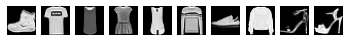

In [ ]:
fig, ax = plt.subplots(1,10)
shapes = []

for i, img in enumerate(x_train):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].axis("off")

## Define some constants

In [ ]:
# arbitrarily set. Feel free to change these
SHUFFLE_SIZE = train_data.cardinality()
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

## Prepare data

In [ ]:
def process_inp(input):
    """ rescale and add channel dimension """
    # normalize between zero and one
    input = input / 255
    # add extra dimension for channel
    input = tf.expand_dims(input, -1)
    return input    

# do process_inp on inputs
x_train = x_train.map(process_inp)
x_test = x_test.map(process_inp)

# zip test input and label
test_data = tf.data.Dataset.zip((x_test, y_test))
# take only first 1000 examples
test_data = test_data.take(1000)


def data_pipeline(data, training):
    """ helper function for data pipeline - does all the things we need """

    if training:
        data = data.shuffle(buffer_size=SHUFFLE_SIZE)

    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

x_train = data_pipeline(x_train, True)
test_data = data_pipeline(test_data, False)

## Define Model

### Encoder

In [ ]:
class Encoder(Model):
    # TODO: Implement init. If necessary, add additional arguments to init. 
    # Please use an output dimension of 10 for the final dense layer.
    def __init__():
        super(Encoder, self).init()
        raise NotImplementedError("TODO: Implement Encoder")

    # TODO: Implement call. If necessary, add additional arguments to call
    def call(x):
        raise NotImplementedError("TODO: Define call")     

#### Check Encoder

In [ ]:
test_inp = next(iter(x_train))
# TODO: @Sascha: Maybe you need to adjust the init arguments?
encoder = Encoder()
out = encoder(x)
# Assert that shape of out is BATCH_SIZE, 10
debug.assert_equal(out.shape, tf.zeros(BATCH_SIZE, 10).shape)

### Decoder

In [ ]:
class Encoder(Model):
    # TODO: Implement init. If necessary, add additional arguments to init. 
    def __init__():
        super(Encoder, self).init()
        raise NotImplementedError("TODO: Implement Encoder")

    # TODO: Implement call. If necessary, add additional arguments to call
    def call(x):
        raise NotImplementedError("TODO: Define call")     

#### Check Decoder

In [ ]:
test_inp = tf.random.uniform((BATCH_SIZE, 10))
# TODO: @Sarah: Maybe you need to adjust the init arguments?
decoder = Decoder()
out = decoder(x)
# Assert that shape of out is BATCH_SIZE, 28, 28, 1
check_tensor = tf.zeros(BATCH_SIZE, 28, 28, 1)
# Check shape
debug.assert_equal(out.shape, check_tensor.shape)
# Check values between 0 and 1
debug.assert_greater_equal(out, check_tensor)
debug.assert_less_equal(out, check_tensor + 1)

### Autoencoder

In [ ]:
class Autoencoder(Model):
    # TODO: adjust init arguments
    def __init__():
        # TODO: adjust init arguments
        self.encoder = Encoder()
        self.decoder = Decoder()

    # TODO: adjust call arguments
    def call(x):    
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
# Leave following things to Hermann: Training, plotting 